# Liver segmenter notebook
This notebook defines, trains, and uses a model trained to segment liver CT scans.

First, we import the stuff we need

In [1]:
import torch
import torch.optim.lr_scheduler as lr_scheduler
import os
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
from monai.utils import first, set_determinism
from monai.data import DataLoader, Dataset, load_decathlon_datalist, check_missing_files, CacheDataset, decollate_batch
from monai.networks.nets import UNet, SegResNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.networks.layers import Norm
from monai.transforms import(
    AsDiscrete,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    LoadImaged,
    Spacingd,
    RandSpatialCropd,
    Orientationd,
    NormalizeIntensityd,
    MapTransform,
    RandFlipd,
    Resized,
    Activations,
    RandScaleIntensityd,
    ScaleIntensityRanged,
    RandCropByPosNegLabeld
)
from monai.config import print_config

# print_config()

Next, load the training data and ensure nothing is missing from it

In [2]:
class ConvertToLiverOneHotd(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            
            # Labels of cancer AND liver are considered part of liver 
            result.append(torch.logical_or(d[key] == 2, d[key] == 1))
            
            # Only cancer encoded separately
            result.append(d[key] == 2)
            
            # Insert the resulting encodings. Inserted at the first axis (in effect, becomes the channel of the input)
            d[key] = torch.stack(result, axis=0).float()
        return d

In [3]:
overall_start = time.time()
keys = ["image","label"]
root_dir = "processing"
data_dir = "Task03_Liver"

train_images = load_decathlon_datalist(os.path.join(data_dir, "dataset.json"), data_list_key="training")
if len(check_missing_files(train_images, keys)) > 0:
   raise Exception("One or more files are missing! Please check your data")
print(f"Training data loaded. {len(train_images)} files ready to be used for training")
train_images, validation_images = train_images[:100], train_images[100:]

Training data loaded. 131 files ready to be used for training


Next: define transforms and load data using the fransforms and put the data into Dataset objects

In [4]:
# We define shared transforms here to avoid double-defining transforms we want for both training and validation data
shared_transforms = [
    LoadImaged(keys=keys),
    EnsureChannelFirstd(keys=keys[0]),
    ConvertToLiverOneHotd(keys=keys[1]),
    Spacingd(keys=keys, pixdim=(1.5, 1.5, 1)),
    Orientationd(keys=keys, axcodes="RAS"),
    ScaleIntensityRanged(keys=keys[0], a_min=-150, a_max=150, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=keys, source_key=keys[0]),
    Resized(keys=keys, spatial_size=(256,256,112))
]

train_transforms = Compose([
    *shared_transforms,
    #RandCropByPosNegLabeld(
    #    keys=keys, 
    #    label_key=keys[1], 
    #    spatial_size=(160,160,64), 
    #    pos=1, 
    #    neg=3, 
    #    allow_smaller=False, 
    #    num_samples=2),
    RandSpatialCropd(keys=keys, roi_size=(160,160,64), random_size=False),
    RandFlipd(keys=keys, spatial_axis=0, prob=0.5),
    RandFlipd(keys=keys, spatial_axis=1, prob=0.5),
    RandScaleIntensityd(keys=keys[0], factors=0.1, prob=1.0)])

validation_transforms = Compose(shared_transforms)

train_dataset = CacheDataset(data=train_images, transform=train_transforms, cache_rate=1.0, num_workers=1)
validation_dataset = Dataset(validation_images, validation_transforms)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=8)

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
Loading dataset: 100%|██████████| 100/100 [18:42<00:00, 11.23s/it]


For the sake of curiosity, lets look at a slice

In [5]:
#validation_data_example = validation_dataset[0]
#slice_i = 150

# Draw the image slice
# plt.figure(figsize=(4, 4))
# plt.imshow(validation_data_example["image"][0, :, :, slice_i], cmap="gray")
# plt.show()

# Draw masks
# fig, (ax1, ax2) = plt.subplots(figsize=((8,8)), ncols=2)
# segmentation_masks = validation_data_example["label"][:, :, :, slice_i]
# ax1.set_title("Liver")
# ax1.imshow(segmentation_masks[0])
# ax2.set_title("Cancer")
# ax2.imshow(segmentation_masks[1])

In [6]:
validation_dataset = CacheDataset(data=validation_images, transform=validation_transforms, cache_rate=1, num_workers=1)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)

Loading dataset: 100%|██████████| 31/31 [05:45<00:00, 11.14s/it]


We want to cache our data so training does not take too long

Define model

In [7]:
device = torch.device("cuda:0")

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(64, 128, 256, 512),
    strides=(2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = DiceLoss(include_background=True, to_onehot_y=False, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), .001)
dice_metric = DiceMetric(include_background=True, reduction="mean")

scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=.1, total_iters=100)

`len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.


In [8]:
epoch_loss_series = []
metrics_series=[]
evaluation_interval = 2
benchmark = 0

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

start_time = time.time()
epochs = 150
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch in train_loader:
        step += 1
        inputs, labels = (batch[keys[0]].to(device), batch[keys[1]].to(device))
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)  
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    scheduler.step()
        
    epoch_loss /= step
    epoch_loss_series.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    if (epoch + 1) % evaluation_interval == 0:
        print("Evaluation in progress...")
        model.eval()
        with torch.no_grad(): # Skip gradient calculation here, no need
            for data in validation_loader:
                validation_inputs, validation_labels = data["image"].to(device), data["label"].to(device)
                outputs = model(validation_inputs)
                outputs = [post_trans(i) for i in decollate_batch(outputs)]
                dice_metric(y_pred=outputs, y=validation_labels)
            
            metric = dice_metric.aggregate().item()
            metrics_series.append(metric)
            if(metric > benchmark): # Save ONLY benchmark models
                benchmark = metric
                torch.save(model.state_dict(), "benchmark_model.pth")
                print(f"Evaluation complete, model saved, new benchmark {benchmark}. Model saved")
            dice_metric.reset()

end_time = time.time()
total_time = end_time - start_time # Time to train
overall_time = end_time - overall_start # Time to prepare the data AND train
print(f"Training took {total_time} seconds to complete")
print(f"The entire process took {overall_time} seconds")

epoch 1 average loss: 0.8544
epoch 2 average loss: 0.8124
Evaluation in progress...
Evaluation complete, model saved, new benchmark 0.23546449840068817. Model saved
epoch 3 average loss: 0.7371
epoch 4 average loss: 0.6940
Evaluation in progress...
Evaluation complete, model saved, new benchmark 0.29479748010635376. Model saved
epoch 5 average loss: 0.6953
epoch 6 average loss: 0.6992
Evaluation in progress...
Evaluation complete, model saved, new benchmark 0.3652319610118866. Model saved
epoch 7 average loss: 0.6888
epoch 8 average loss: 0.6682
Evaluation in progress...
epoch 9 average loss: 0.6407
epoch 10 average loss: 0.6361
Evaluation in progress...
Evaluation complete, model saved, new benchmark 0.3858635723590851. Model saved
epoch 11 average loss: 0.6293
epoch 12 average loss: 0.6657
Evaluation in progress...
epoch 13 average loss: 0.6092
epoch 14 average loss: 0.6145
Evaluation in progress...
epoch 15 average loss: 0.6176
epoch 16 average loss: 0.6214
Evaluation in progress...

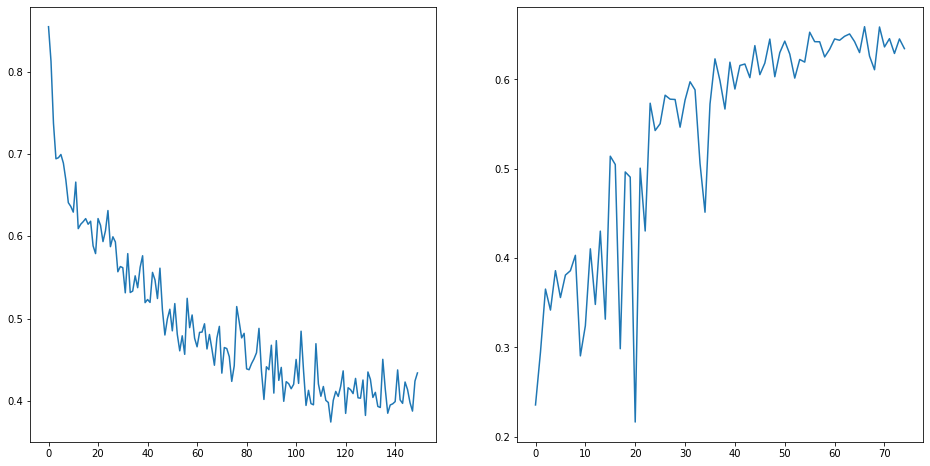

In [19]:
def plot_series(series, axis):
    x_vals = np.arange(0, len(series), dtype=int)
    axis.plot(x_vals, series)

fig, (ax1,ax2) = plt.subplots(figsize=(16,8), ncols=2)
plot_series(epoch_loss_series, ax1)
plot_series(metrics_series, ax2)
plt.savefig(f"result/res{time.time()}at{benchmark}.png")

with open("result/results.txt", 'w') as file:
    file.write(f"Best result {benchmark}. Model matching benchmark saved")

Here we will do testing

torch.Size([1, 2, 256, 256, 112])


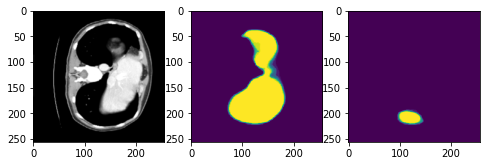

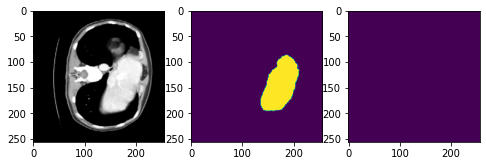

In [30]:
test_images = load_decathlon_datalist(os.path.join(data_dir, "dataset.json"), data_list_key="test")
test_image_transforms = Compose([
    LoadImaged(keys=keys[0]),
    EnsureChannelFirstd(keys=keys[0]),
    CropForegroundd(keys=keys[0], source_key=keys[0]),
    Orientationd(keys=keys[0], axcodes="RAS"),
    NormalizeIntensityd(keys=keys[0], nonzero=True, channel_wise=True),
    Resized(keys=keys[0], spatial_size=(256,256,64))
])

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
test_dataset = Dataset(test_images, transform=test_image_transforms)
model.load_state_dict(torch.load("benchmark_model.pth"))
model.eval()

def draw_comparison_figure(original, mask, slice, has_label=False):
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(8,8), ncols=3)
    ax1.imshow(original["image"][0, :, :, slice].detach().cpu(), cmap="gray")
    if(has_label):
        ax2.imshow(mask["label"][0, :, :, slice].detach().cpu())
        ax3.imshow(mask["label"][1, :, :, slice].detach().cpu())
    else:
        ax2.imshow(mask[0,0, :, :, slice].detach().cpu())
        ax3.imshow(mask[0,1, :, :, slice].detach().cpu())

i = 23
## Compare with validation image
with torch.no_grad():
    input_image = validation_dataset[i]["image"].unsqueeze(0).to(device)
    output = model(input_image)
    output = post_trans(output)
    print(output.shape)
    
    inspect_slice = 99
    draw_comparison_figure(validation_dataset[i], validation_dataset[0], inspect_slice, True)
    draw_comparison_figure(validation_dataset[i], output, inspect_slice, False)
    
plt.savefig(f"result/comparison{i}")